# Cargue y preentrenamiento de datos

In [1]:
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

#***********************************************************************************************************

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/MLRSNet_Reducido'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta

#***********************************************************************************************************
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

#***********************************************************************************************************

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3,'park': 4,'stadium': 5,'tennis_court': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))

#***********************************************************************************************************

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))

#***********************************************************************************************************

# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))



C:\Users\nicol\AppData\Local\Temp\ipykernel_10492\1372690417.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.
Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 622, 1: 638, 2: 649, 3: 651, 4: 650, 5: 625, 6: 667}
Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 667, 1: 667, 2: 667, 3: 667, 4: 667, 5: 667, 6: 667}
Número de ejemplos de entrenamiento antes del balanceo: 4502
Número de ejemplos de entrenamiento después del balanceo: 4669
Número de ejemplos de prueba: 1126


# Entrenamiento modelo customizado

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(7, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,935 (60.14 MB)

 Trainable params: 15,764,935 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.4199 - loss: 1.7823 - val_accuracy: 0.7946 - val_loss: 0.6225
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 131s 885ms/step - accuracy: 0.8008 - loss: 0.6040 - val_accuracy: 0.8732 - val_loss: 0.3925
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 129s 882ms/step - accuracy: 0.8660 - loss: 0.3849 - val_accuracy: 0.9321 - val_loss: 0.2367
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 130s 894ms/step - accuracy: 0.9199 - loss: 0.2566 - val_accuracy: 0.9589 - val_loss: 0.1551
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 129s 885ms/step - accuracy: 0.9624 - loss: 0.1380 - val_accuracy: 0.9807 - val_loss: 0.0802
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 130s 889ms/step - accuracy: 0.9820 - loss: 0.0749 - val_accuracy: 0.9786 - val_loss: 0.0724
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 129s 885ms/step - accuracy: 0.9854 - loss: 0.0542 - val_accuracy: 0.9972 - val_loss: 0.0191
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 129s 886ms/step - accuracy: 0.9985 - lo

Precision: 0.8455259201205099
Recall: 0.844582593250444
F1 Score: 0.8440536341097279
Accuracy: 0.844582593250444
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.88      0.85      0.87       182
  basketball_court       0.85      0.87      0.86       166
       golf_course       0.84      0.90      0.87       155
ground_track_field       0.83      0.84      0.83       153
              park       0.83      0.91      0.87       154
           stadium       0.88      0.78      0.82       179
      tennis_court       0.80      0.77      0.78       137

          accuracy                           0.84      1126
         macro avg       0.84      0.84      0.84      1126
      weighted avg       0.85      0.84      0.84      1126



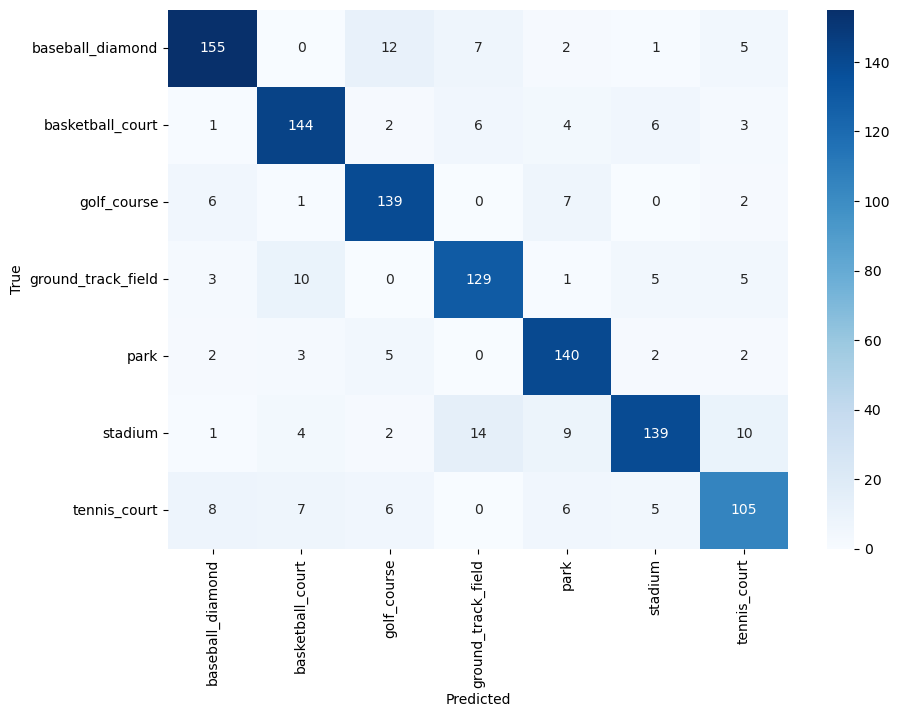

In [4]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/MLSRNet/MLRSNet_Custom.h5')

# Entrenamiento con VGG16

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)


Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.3912 - loss: 2.2218 - val_accuracy: 0.7993 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.6527 - loss: 0.9118 - val_accuracy: 0.8268 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.6898 - loss: 0.7832 - val_accuracy: 0.8481 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.7106 - loss: 0.7063 - val_accuracy: 0.8561 - val_loss: 0.4429 - learning_rate: 9.0484e-04
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.7517 - loss: 0.6123 - val_accuracy: 0.8659 - val_loss: 0.4006 - learning_rate: 8.1873e-04
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.7769 - loss: 0.5563 - val_accuracy: 0.8801 - val_loss: 0.3764 - learning_rate: 7.4082e-04
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.780

36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step
Precision: 0.8901632027071523
Recall: 0.8872113676731794
F1 Score: 0.8878405821747204
Accuracy: 0.8872113676731794
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.98      0.90      0.94       182
  basketball_court       0.85      0.88      0.87       166
       golf_course       0.86      0.91      0.88       155
ground_track_field       0.86      0.90      0.88       153
              park       0.88      0.88      0.88       154
           stadium       0.94      0.86      0.90       179
      tennis_court       0.83      0.88      0.86       137

          accuracy                           0.89      1126
         macro avg       0.89      0.89      0.89      1126
      weighted avg       0.89      0.89      0.89      1126



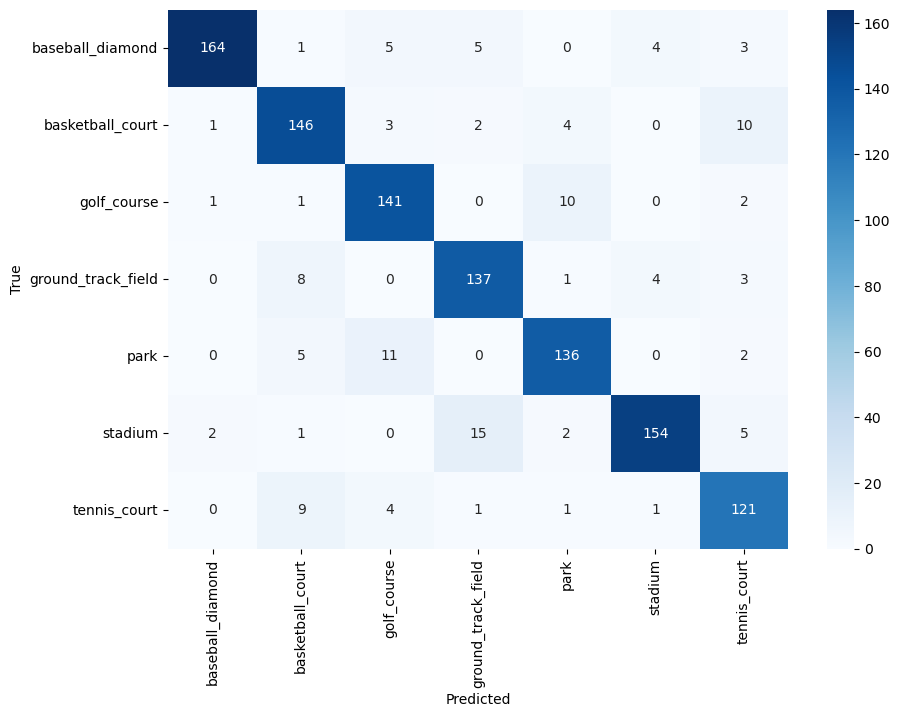

In [7]:
#******************************************************************************************


# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [8]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/MLSRNet/MLRSNet_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.5085 - loss: 3.0955 - val_accuracy: 0.6892 - val_loss: 0.8604 - learning_rate: 0.0010
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.5883 - loss: 1.0959 - val_accuracy: 0.8393 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 479s 3s/step - accuracy: 0.7047 - loss: 0.8002 - val_accuracy: 0.8766 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.7217 - loss: 0.6985 - val_accuracy: 0.8535 - val_loss: 0.4671 - learning_rate: 9.0484e-04
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.7579 - loss: 0.6528 - val_accuracy: 0.8961 - val_loss: 0.3366 - learning_rate: 8.1873e-04
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.7990 - loss: 0.5301 - val_accuracy: 0.8979 - val_loss: 0.3700 - learning_rate: 7.4082e-04
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.822

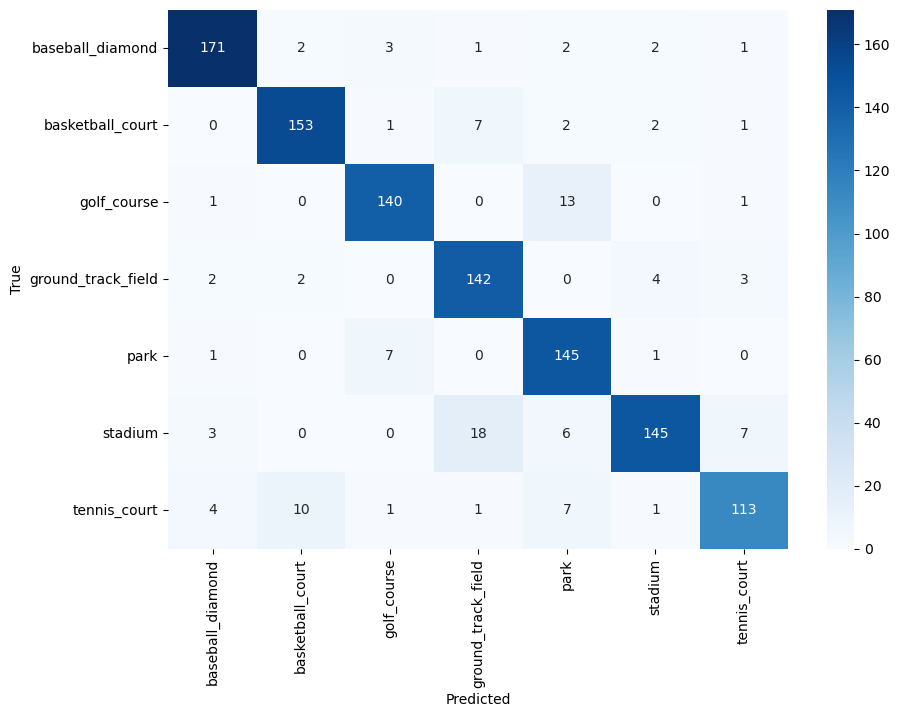

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)



36/36 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step
Precision: 0.8990407597834129
Recall: 0.8960923623445826
F1 Score: 0.8958639399329251
Accuracy: 0.8960923623445826
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.94      0.94      0.94       182
  basketball_court       0.92      0.92      0.92       166
       golf_course       0.92      0.90      0.91       155
ground_track_field       0.84      0.93      0.88       153
              park       0.83      0.94      0.88       154
           stadium       0.94      0.81      0.87       179
      tennis_court       0.90      0.82      0.86       137

          accuracy                           0.90      1126
         macro avg       0.90      0.90      0.89      1126
      weighted avg       0.90      0.90      0.90      1126



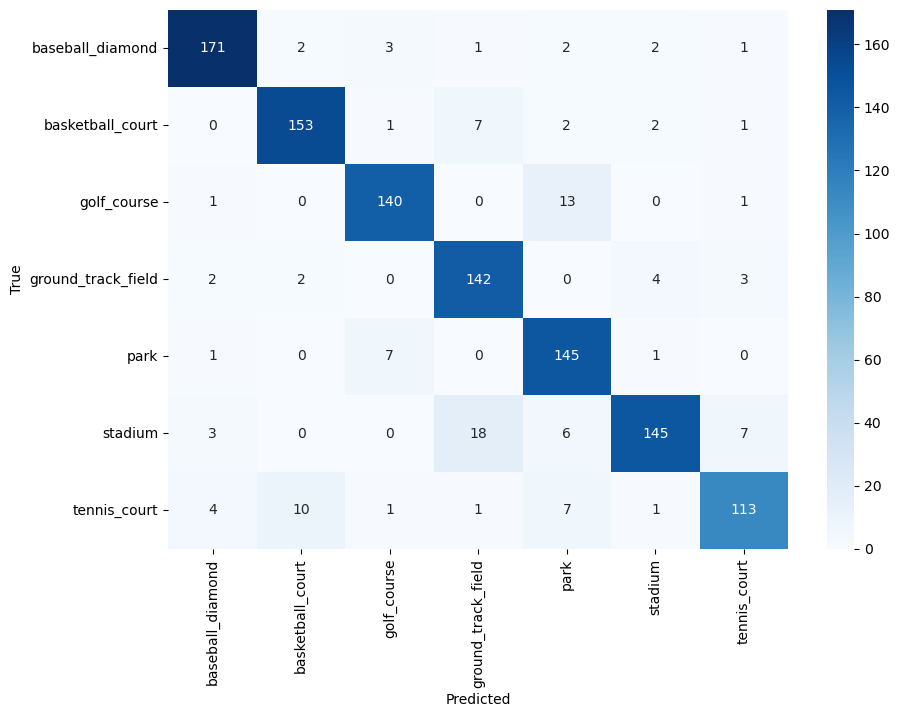

In [11]:
#*********************************************************************************************
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [12]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/MLSRNet/MLRSNet_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [13]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/MLRSNet_Reducido'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3, 'park': 4,'stadium': 5,'tennis_court': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.41051589613397643
Validation Loss: 0.14393440049348605
Epoch 2, Loss: 0.20647167329587143
Validation Loss: 0.11370761454519299
Epoch 3, Loss: 0.12550628124034569
Validation Loss: 0.1166010536512153
Epoch 4, Loss: 0.05690253620141199
Validation Loss: 0.06064109900681716
Epoch 5, Loss: 0.02338023615757016
Validation Loss: 0.05228732906511545
Epoch 6, Loss: 0.01605990702646772
Validation Loss: 0.04965407262352528
Epoch 7, Loss: 0.014101603168082002
Validation Loss: 0.04825964875554847
Epoch 8, Loss: 0.012991926181512847
Validation Loss: 0.04887474858050053
Epoch 9, Loss: 0.013113041971698531
Validation Loss: 0.04748730588350251
Epoch 10, Loss: 0.012143163950172928
Validation Loss: 0.047732515110611634
Epoch 11, Loss: 0.011825994315735791
Validation Loss: 0.04689923842104488
Epoch 12, Loss: 0.013689907046620198
Validation Loss: 0.04742651115763389
Epoch 13, Loss: 0.013194187229725672
Validation Loss: 0.046110872449692884
Epoch 14, Loss: 0.013894611051424139
Validation Loss

Precision: 0.9876023282435186
Recall: 0.9875666074600356
F1 Score: 0.9875548926735306
Accuracy: 0.9875666074600356
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.98      0.98      0.98       182
  basketball_court       1.00      1.00      1.00       166
       golf_course       0.98      1.00      0.99       155
ground_track_field       0.98      0.98      0.98       153
              park       1.00      1.00      1.00       154
           stadium       0.98      0.98      0.98       179
      tennis_court       0.99      0.97      0.98       137

          accuracy                           0.99      1126
         macro avg       0.99      0.99      0.99      1126
      weighted avg       0.99      0.99      0.99      1126



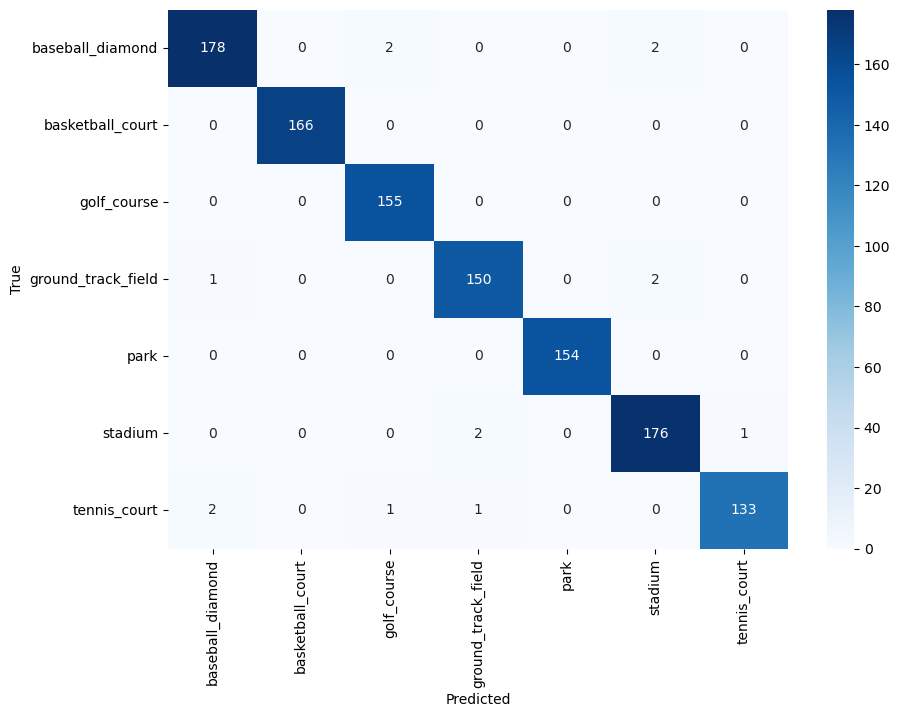

In [14]:
# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/MLSRNet/MLRSNet_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [16]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field', 'park','stadium','tennis_court']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/MLRSNet_Reducido'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3, 'park': 4,'stadium': 5,'tennis_court': 6}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5017841950263062
Validation Loss: 0.3695445501555999
Epoch 2, Loss: 0.2518088580683282
Validation Loss: 0.2680420902454191
Epoch 3, Loss: 0.16058532888554547
Validation Loss: 0.6117655850119061
Epoch 4, Loss: 0.05771577889928977
Validation Loss: 0.07690037058071336
Epoch 5, Loss: 0.026766255695679007
Validation Loss: 0.07317763103896545
Epoch 6, Loss: 0.0185664271104966
Validation Loss: 0.07512896750833736
Epoch 7, Loss: 0.014921441752374275
Validation Loss: 0.06867127352031982
Epoch 8, Loss: 0.01594126970931403
Validation Loss: 0.07048928153946893
Epoch 9, Loss: 0.015816644859127062
Validation Loss: 0.07152580197887598
Epoch 10, Loss: 0.010746856230432296
Validation Loss: 0.07245099989167
Early stopping triggered


Precision: 0.978748221163354
Recall: 0.9786856127886323
F1 Score: 0.9786511460730101
Accuracy: 0.9786856127886323
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       1.00      0.98      0.99       182
  basketball_court       0.99      0.99      0.99       166
       golf_course       0.97      1.00      0.99       155
ground_track_field       0.96      0.95      0.96       153
              park       0.99      1.00      0.99       154
           stadium       0.96      0.97      0.96       179
      tennis_court       0.98      0.96      0.97       137

          accuracy                           0.98      1126
         macro avg       0.98      0.98      0.98      1126
      weighted avg       0.98      0.98      0.98      1126



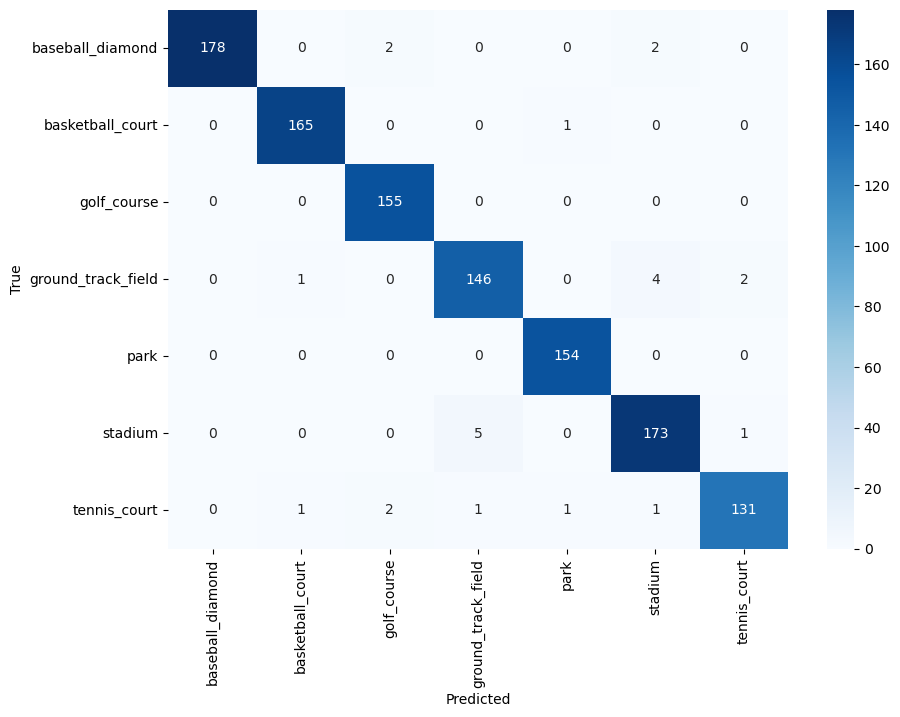

In [17]:

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/MLSRNet/MLRSNet_ResNET18.pth')